# Parameter modification and goodness-of-fit calculations

In parameterizing hydrological models, it's necesary to test multiple parameters and calculate the goodness-of-fit for each model run. Goodness-of-fit is a measure of how well the model output matches historical output so that future predictions may be made. A well-known GOF measure in Hydrology is the Nash-Sutcliffe model efficiency, from Nash & Sutcliffe's 1970 paper [River Flow Forecasting Through Conceptual Models Part I - A Discussion of Principles](./nash-sutcliffe-1970.pdf). They elegantly describe the model-fitting problem like so

> To remove subjectivity in fitting the model to the data or in determining the
parametric values, O'Donnell3) suggested automatic optimisation. This
involves successive changes of parameter values according to some pre-conceived
rule or pattern of increments which takes into account the results of
previous steps and in particular whether or not a change improved the fitting.  

The equation itself is

\begin{equation}
E = 1 - \frac{\sum_{t=1}^{T}\left(Q_o^t - Q_m^t\right)^2}{\sum_{t=1}^{T}\left(Q_o^t - \overline{Q_o}\right)^2}
\end{equation}

This may appear to be somewhat imposing, but it's quite easy to break down and understand, and to code in Python. 
If $E = 1$ this means that all variance is accounted for by the model. If $E=0$ it follows that the mean of the historical values is as good a predictor as the model itself. If $E < 0$, then the mean is a better predictor than the model.

The cell below defines the Nash-Sutcliffe goodness of fit for later use.

/usr/local/lib/python2.7/site-packages/mpltools/style/__init__.py:42: FutureWarning: 

    The style-sheet functionality in mpltools has been integrated into
    Matplotlib >= 1.4. This module will be removed in a future release.

    Note that style-sheets used by `matplotlib.style` use the standard
    Matplotlib rc-file syntax instead of the INI format used by `mpltools`.
    This mostly means un-quoting strings and changing '=' to ':'.


  """, FutureWarning)
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


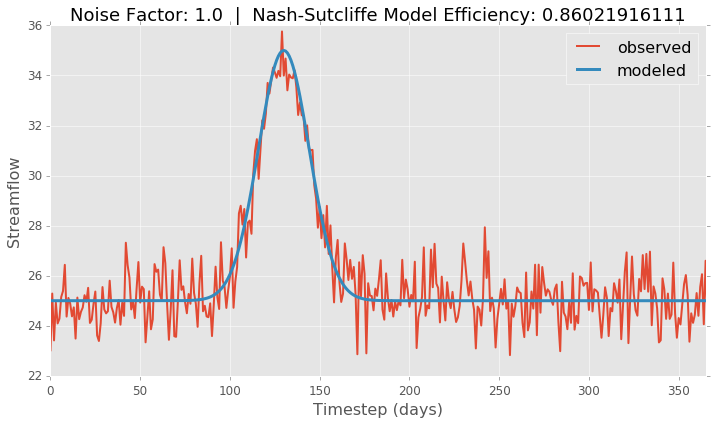

In [11]:
%matplotlib inline
from mpltools import style
style.use('ggplot')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10.0, 6.0)
mpl.rcParams['figure.dpi'] = 300.0
mpl.rcParams['xtick.labelsize'] = 12.0
mpl.rcParams['ytick.labelsize'] = 12.0
mpl.rcParams['axes.labelsize'] = 16.0
mpl.rcParams['axes.titlesize'] = 18.0
mpl.rcParams['legend.fontsize'] = 16.0

import numpy as np
import matplotlib.pyplot as plt

def nash_sutcliffe(observed, modeled):
    """
    Calculates the Nash-Sutcliffe Goodness-of-fit
    
    Arguments:
        observed (numpy.ndarray): historic observational data
        modeled (numpy.ndarray): 
    """
    numerator = sum((observed - modeled)**2)
    denominator = sum((observed - np.mean(observed))**2)
    
    return 1 - (numerator/denominator)

# Exampe use

# add noise to the observations; the more noise, the poorer the fit
# corresponds to amplitude of added Gaussian noise
peak_streamflow_amplitude = 10.0
peak_streamflow_day = 130
peak_streamflow_x = 0.05 * peak_streamflow_day
base_streamflow = 25.0
noise_factor = 1.0

x = np.arange(0, 18.5, 0.05)
q_obs = base_streamflow + \
        (peak_streamflow_amplitude*np.exp(-((x - peak_streamflow_x)**2)) + \
        noise_factor*np.random.normal(size=len(x)))
    
q_model = base_streamflow + peak_streamflow_amplitude*np.exp(-((x - peak_streamflow_x)**2))

ns = nash_sutcliffe(q_obs, q_model)

plt.plot(q_obs, lw=2.0, label='observed')
plt.plot(q_model, lw=3.0, label='modeled')
plt.ylabel('Streamflow')
plt.xlabel('Timestep (days)')

plt.xlim([0, 365])
plt.legend()
plt.title('Noise Factor: {0}  |  Nash-Sutcliffe Model Efficiency: {1}'.format(noise_factor, ns))

## Questions to think about

### Will the Nash-Sutcliffe efficiency be the same for every run of the above cell?

### Is there a threshold noise factor where the Nash-Sutcliffe factor goes from positive to negative? What is it?

Write a script below to investigate.

## Load and Plot Historical Data

As a first step towards using the Nash-Sutcliffe model efficiency in parameterizing PRMS ourselves, let's first import the historic timeseries and plot it. It's contained in the Incline Village data netCDF, which we'll load with [xarray](http://xarray.pydata.org/en/stable/) which allows intuitive variable selection, subsetting, and plotting.

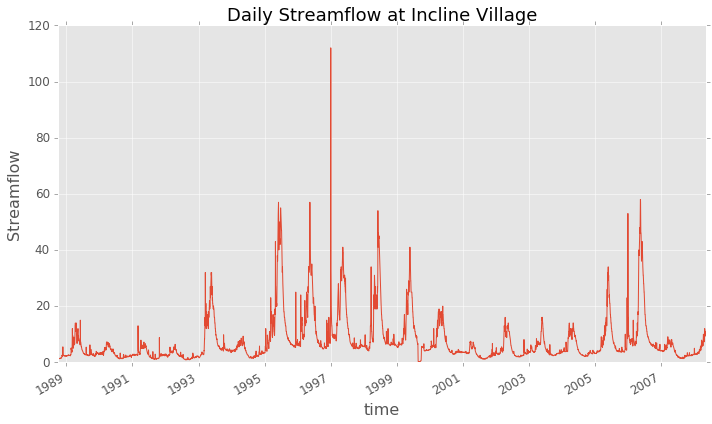

In [29]:
from xarray import open_dataset

iv_data = open_dataset('data/data.nc')
q_observed = iv_data.runoff_3
q_observed.plot()
plt.ylabel('Streamflow')
plt.title('Daily Streamflow at Incline Village')

This is nice, but at a very small timestep relative to the time window we're working with: daily timestep with almost twenty years of data. xarray allows us to intuitively [resample](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.resample.html?highlight=resample#xarray.DataArray.resample) over the time dimension and plot again. When resampling we must specify the aggregation to do over the requested frequency. We tell xarray to resample every two weeks by summing the streamflow in a two-week range. We sum instead of average so that we conserve the total streamflow represented by the timeseries.

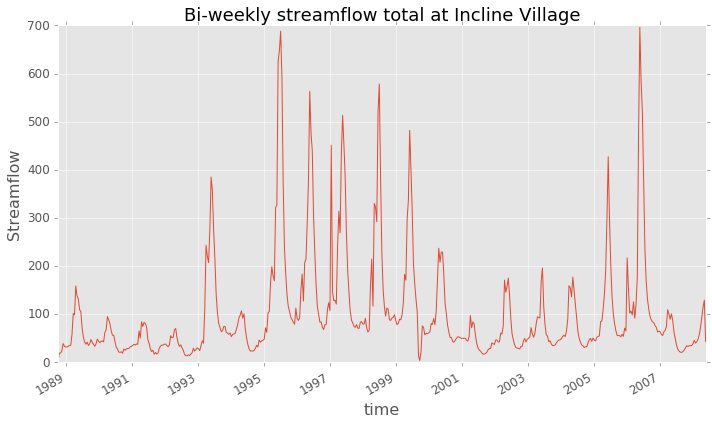

In [138]:
q_observed_biweekly = q_observed.resample('2W', 'time', how='sum')
q_observed_biweekly.plot()
plt.ylabel('Streamflow')
plt.title('Bi-weekly streamflow total at Incline Village')

Next we will run PRMS on the data we have in the `data` directory and send the `statsvar.nc` output to the `prms-base-run` directory. We call it "base" because we have not modified parameters at all. After this runs and we compare the results, we will generate outputs based on different parameterizations then compare all those results.

In [139]:
from capstone_util import run_prms
# we can always ask for help from the Jupyter notebook
help(run_prms)

Help on function run_prms in module capstone_util:

run_prms(data, param, control, jwt, output_dir, modelrun_title=None, auth_host='https://auth-test.virtualwatershed.org/api', model_host='https://model-test.virtualwatershed.org/api', clobber=True, verify_ssl=False)
    Wrapper for running PRMS using the



In [140]:
import jwt
token = jwt.TOKEN
run_prms('data/data.nc', 'data/parameter.nc', 'data/incline_village.control', 
         token, 'prms-base-run', modelrun_title='base parametrization')

uploading data
uploading param


KeyboardInterrupt: 

## Modify parameters

Our PRMS parameters are in `data/parameter.nc`. We'll create a function that will return another function that scales the air temperature for the Jensen-Haise potential ET computations (`jh_coef_hru`) and we'll also scale the transmission coefficient for short-wave radiation through the winter vegetation canopy (`rad_trncf`).

In [27]:
import netCDF4
d = netCDF4.Dataset('data/parameter.nc')

params = d.variables.keys()
print 'jh_coef_hru' in params
print 'rad_trncf' in params

True
True


In [ ]:
from capstone_util import scale_params_fun_generator, create_prms_scenario_inputs

param_mod_fun = scale_params_fun_generator(jh_coef_hru=1.1)

create_prms_scenario_inputs('data/data.nc', 'data/parameter.nc', 'data/incline_village.control', 
                            'jh_coef_hru-1.1', param_mod_fun=param_mod_fun)

In [ ]:
#run_prms('jh_coef_hru-1.1/data.nc', 'jh_coef_hru-1.1/parameter.nc', 'jh_coef_hru-1.1/incline_village.control',
 #        token, 'jh_coef_hru-1.1-run', modelrun_title='Increase JH Coefficient by 10% at all HRU')

## Calculate the goodness of fit for the base parameters and modified jh_coef_hru

Now we'll use xarray again to load the hydrographs of the two model runs we performed. We will plot the three streamflow timeseries (observed and two modeled) and calculate the Nash-Sutcliffe Model Efficiency.

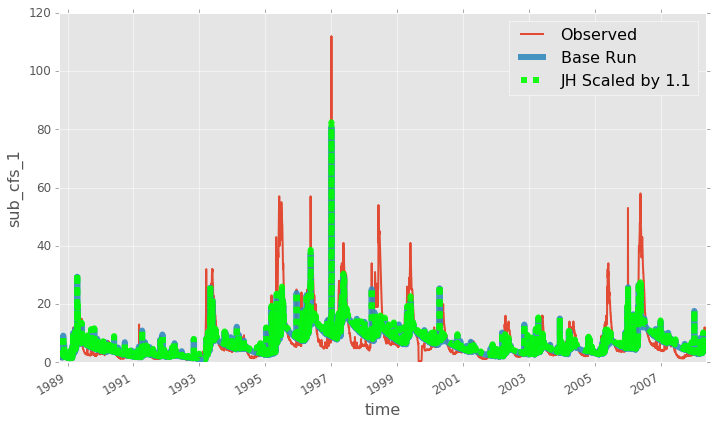

In [30]:
base_model = open_dataset('base-iv-run/statsvar.nc')
q_base_model = base_model.sub_cfs_1

q_jh_11 = open_dataset('jh_coef_hru-1.1-run/statsvar.nc').sub_cfs_1

base_plot_opts = dict(lw=6, ms=12, label='Base Run', alpha=0.9)
jh_11_plot_opts = dict(lw=6, label='JH Scaled by 1.1', ls='--', color='lime', alpha=0.9)

q_observed.plot(lw=2, label='Observed')
q_base_model.plot(**base_plot_opts)
q_jh_11.plot(**jh_11_plot_opts)

plt.legend()

Again it's hard to tell much about what's happening, so let's try resampling to get a better feel for the differences between the two.

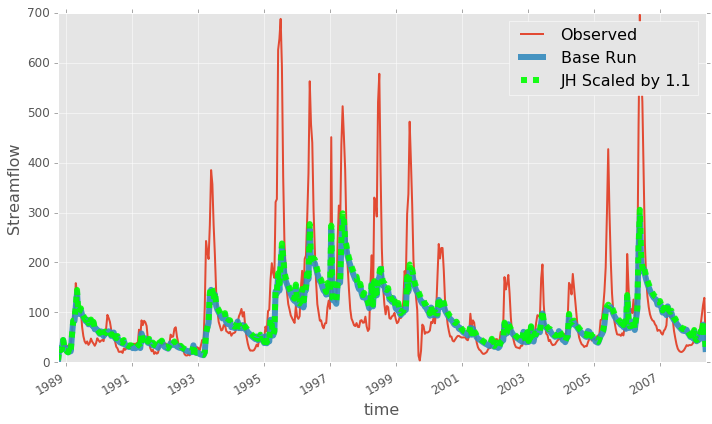

In [31]:
q_observed_resampled = q_observed.resample('2W', 'time', how='sum')
q_base_model_resampled = q_base_model.resample('2W', 'time', how='sum')
q_jh_11_resampled = q_jh_11.resample('2W', 'time', how='sum')

q_observed_resampled.plot(lw=2, label='Observed')
q_base_model_resampled.plot(**base_plot_opts)
q_jh_11_resampled.plot(**jh_11_plot_opts)

plt.ylabel('Streamflow')

plt.legend()

In [133]:
max(q_base_model.to_masked_array() - q_jh_11.to_masked_array())

0.021095037

So the graphs look very similar, and indeed are, with the greatest difference between any two timesteps being 0.02 cubic feet per second. The Efficiency then should be very similar between the two. Let's calculate that:

In [153]:
ns_base = nash_sutcliffe(q_observed.to_masked_array(), q_base_model.to_masked_array())
ns_jh_11 = nash_sutcliffe(q_observed.to_masked_array(), q_jh_11.to_masked_array())

print "Base: {}".format(ns_base)
print "JH inc by 10%: {}".format(ns_jh_11)

Base: 0.434923028353
JH inc by 10%: 0.451576281013


## Scale with many scale factors and two parameters

Parameterization is the process of finding the appropriate parameters to get the model to most closely match the observations. We will now create sixteen scenarios, then run PRMS on all of them. We will use the power of the Virtual Watershed modeling server to run all sixteen "asynchronously", meaning that we don't have to wait for one scenario to be done for the next to run. As computing resources become available, the model server runs all requests it receives.

I originally ran the experiment with five scale factors, but that has been commented out so if someone runs this fresh the run will only take 9/25 of the time it would otherwise have taken.

In [156]:
#scale_factors = [0.8, 0.9, 1.0, 1.1, 1.2]
scale_factors = [0.9, 1.0, 1.1]
scale_pairs = [(s1, s2) for s1 in scale_factors for s2 in scale_factors]

for jh_factor, rad_trncf_factor in scale_pairs:

    param_mod_fun = scale_params_fun_generator(jh_coef_hru=jh_factor, rad_trncf=rad_trncf_factor)

    create_prms_scenario_inputs('data/data.nc', 'data/parameter.nc', 'data/incline_village.control', 
                                'jh_{}_rad_{}'.format(jh_factor, rad_trncf_factor), 
                                param_mod_fun=param_mod_fun)

In [164]:
import os
import glob
scenario_dirs = [d for d in glob.glob('jh_*_rad_*') if os.path.isdir(d) and 'output' not in d]

print scenario_dirs

['jh_0.8_rad_0.8', 'jh_0.8_rad_0.9', 'jh_0.8_rad_1.0', 'jh_0.8_rad_1.1', 'jh_0.8_rad_1.2', 'jh_0.9_rad_0.8', 'jh_0.9_rad_0.9', 'jh_0.9_rad_1.0', 'jh_0.9_rad_1.1', 'jh_0.9_rad_1.2', 'jh_1.0_rad_0.8', 'jh_1.0_rad_0.9', 'jh_1.0_rad_1.0', 'jh_1.0_rad_1.1', 'jh_1.0_rad_1.2', 'jh_1.1_rad_0.8', 'jh_1.1_rad_0.9', 'jh_1.1_rad_1.0', 'jh_1.1_rad_1.1', 'jh_1.1_rad_1.2', 'jh_1.2_rad_0.8', 'jh_1.2_rad_0.9', 'jh_1.2_rad_1.0', 'jh_1.2_rad_1.1', 'jh_1.2_rad_1.2']


In [ ]:
from capstone_util import run_many_prms
# run_many_prms automatically creates the output directories and names each model run
run_many_prms(scenario_dirs, token)

In [10]:
# downloads might fail, need to re-download by inspecting first id done and ranging to that id plus 25
from capstone_util import download_many_outputs
from jwt import TOKEN
token = TOKEN
mr_range = range(67, 67+25)
download_many_outputs(mr_range, token)

In [ ]:
# load each statsvar output into a dictionary entry as a series, keyed by output dir name
import os
from xarray import open_dataset

output_dirs = glob.glob('*-output')
print output_dirs
modeled_flows = {
    d: open_dataset(os.path.join(d, 'statsvar.nc')).sub_cfs_1.to_masked_array()
    for d in output_dirs
}
# calculate Nash-Sutcliffe for each one
d = open_dataset('data/data.nc')
q_observed = d.runoff_3.to_masked_array()
t = d.time
d.close()
nash_sutcliffe_vals = {
    d: nash_sutcliffe(q_observed, modeled_flow)
    for d, modeled_flow in modeled_flows.iteritems()
}

# matshow the result with scale values on each axis
idx_lookup = {'0.8': 0, '0.9': 1, '1.0': 2, '1.1': 3, '1.2': 4}
nash_sutcliffe_mat = np.zeros((5,5))
for d, ns in nash_sutcliffe_vals.iteritems():
    dspl = d.split('_')
    jh_factor = dspl[1]
    rad_factor = dspl[-1].split('-')[0]
    coord = (idx_lookup[jh_factor], idx_lookup[rad_factor])
    nash_sutcliffe_mat[coord] = ns

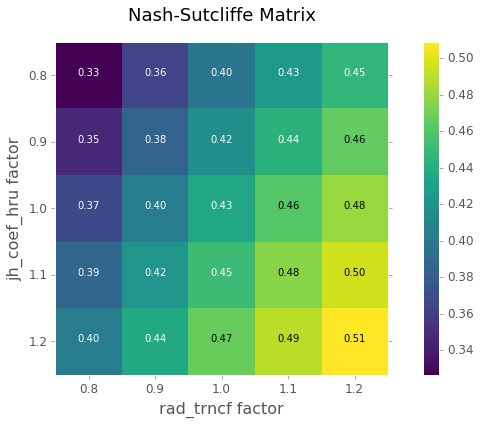

In [50]:
import itertools
fig, ax = plt.subplots()

cax = ax.matshow(nash_sutcliffe_mat, cmap='viridis')
tix = [0.8, 0.9, 1.0, 1.1, 1.2]
plt.xticks(range(5), tix)
plt.yticks(range(5), tix)


ax.xaxis.set_ticks_position('bottom')
plt.ylabel('jh_coef_hru factor')
plt.xlabel('rad_trncf factor')

for i, j in itertools.product(range(5), range(5)):
    plt.text(j, i, "%.2f" % nash_sutcliffe_mat[i, j],
             horizontalalignment="center", 
             color="w" if nash_sutcliffe_mat[i, j] < .46 else "k")

plt.title('Nash-Sutcliffe Matrix')
plt.grid(b=False)
cbar = fig.colorbar(cax)

In [48]:
# spot check to make sure our indexing was correct
print nash_sutcliffe_vals['jh_1.2_rad_1.2-output']
print nash_sutcliffe_vals['jh_1.1_rad_1.2-output']
print nash_sutcliffe_vals['jh_1.2_rad_1.1-output']
print nash_sutcliffe_vals['jh_1.0_rad_1.0-output']

0.508706379829
0.49564468608
0.48998174195
0.434923028353


In [ ]:
# as a further demo, plot five slices across jh coefficient with five plots of varying rad_trncf

In [54]:
from capstone_util import create_prms_scenario_inputs, scale_params_fun_generator

#scale_factors = [0.8, 0.9, 1.0, 1.1, 1.2]
scale_factors = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
scale_pairs = [(s1, s2) for s1 in scale_factors for s2 in scale_factors]

for jh_factor, rad_trncf_factor in scale_pairs:

    param_mod_fun = scale_params_fun_generator(jh_coef_hru=jh_factor, rad_trncf=rad_trncf_factor)

    create_prms_scenario_inputs('data/data.nc', 'data/parameter.nc', 'data/incline_village.control', 
                                'wider-jh_{}_rad_{}'.format(jh_factor, rad_trncf_factor), 
                                param_mod_fun=param_mod_fun)

In [55]:
import os
import glob
scenario_dirs = [d for d in glob.glob('wider-jh_*_rad_*') if os.path.isdir(d) and 'output' not in d]

print scenario_dirs

['wider-jh_1.1_rad_1.1', 'wider-jh_1.1_rad_1.2', 'wider-jh_1.1_rad_1.3', 'wider-jh_1.1_rad_1.4', 'wider-jh_1.1_rad_1.5', 'wider-jh_1.1_rad_1.6', 'wider-jh_1.1_rad_1.7', 'wider-jh_1.1_rad_1.8', 'wider-jh_1.1_rad_1.9', 'wider-jh_1.1_rad_2.0', 'wider-jh_1.2_rad_1.1', 'wider-jh_1.2_rad_1.2', 'wider-jh_1.2_rad_1.3', 'wider-jh_1.2_rad_1.4', 'wider-jh_1.2_rad_1.5', 'wider-jh_1.2_rad_1.6', 'wider-jh_1.2_rad_1.7', 'wider-jh_1.2_rad_1.8', 'wider-jh_1.2_rad_1.9', 'wider-jh_1.2_rad_2.0', 'wider-jh_1.3_rad_1.1', 'wider-jh_1.3_rad_1.2', 'wider-jh_1.3_rad_1.3', 'wider-jh_1.3_rad_1.4', 'wider-jh_1.3_rad_1.5', 'wider-jh_1.3_rad_1.6', 'wider-jh_1.3_rad_1.7', 'wider-jh_1.3_rad_1.8', 'wider-jh_1.3_rad_1.9', 'wider-jh_1.3_rad_2.0', 'wider-jh_1.4_rad_1.1', 'wider-jh_1.4_rad_1.2', 'wider-jh_1.4_rad_1.3', 'wider-jh_1.4_rad_1.4', 'wider-jh_1.4_rad_1.5', 'wider-jh_1.4_rad_1.6', 'wider-jh_1.4_rad_1.7', 'wider-jh_1.4_rad_1.8', 'wider-jh_1.4_rad_1.9', 'wider-jh_1.4_rad_2.0', 'wider-jh_1.5_rad_1.1', 'wider-jh_1.5_r

In [56]:
from capstone_util import run_many_prms
# run_many_prms automatically creates the output directories and names each model run
run_many_prms(scenario_dirs, token)

current state: {94: 'FINISHED', 95: 'FINISHED', 96: 'FINISHED', 97: 'FINISHED', 98: 'FINISHED', 99: 'FINISHED', 100: 'FINISHED', 101: 'FINISHED', 102: 'FINISHED', 103: 'FINISHED', 104: 'FINISHED', 105: 'FINISHED', 106: 'FINISHED', 107: 'FINISHED', 108: 'FINISHED', 109: 'FINISHED', 110: 'FINISHED', 111: 'FINISHED', 112: 'FINISHED', 113: 'FINISHED', 114: 'FINISHED', 115: 'FINISHED', 116: 'FINISHED', 117: 'FINISHED', 118: 'FINISHED', 119: 'FINISHED', 120: 'FINISHED', 121: 'FINISHED', 122: 'FINISHED', 123: 'FINISHED', 124: 'FINISHED', 125: 'FINISHED', 126: 'FINISHED', 127: 'FINISHED', 128: 'FINISHED', 129: 'FINISHED', 130: 'FINISHED', 131: 'FINISHED', 132: 'FINISHED', 133: 'FINISHED', 134: 'FINISHED', 135: 'FINISHED', 136: 'FINISHED', 137: 'FINISHED', 138: 'FINISHED', 139: 'FINISHED', 140: 'FINISHED', 141: 'FINISHED', 142: 'FINISHED', 143: 'FINISHED', 144: 'FINISHED', 145: 'FINISHED', 146: 'FINISHED', 147: 'QUEUED', 148: 'FINISHED', 149: 'FINISHED', 150: 'QUEUED', 151: 'QUEUED', 152: 'FINI

KeyboardInterrupt: 

In [4]:
run_many_lookup = {94: 'FINISHED', 95: 'FINISHED', 96: 'FINISHED', 97: 'FINISHED', 98: 'FINISHED', 99: 'FINISHED', 100: 'FINISHED', 101: 'FINISHED', 102: 'FINISHED', 103: 'FINISHED', 104: 'FINISHED', 105: 'FINISHED', 106: 'FINISHED', 107: 'FINISHED', 108: 'FINISHED', 109: 'FINISHED', 110: 'FINISHED', 111: 'FINISHED', 112: 'FINISHED', 113: 'FINISHED', 114: 'FINISHED', 115: 'FINISHED', 116: 'FINISHED', 117: 'FINISHED', 118: 'FINISHED', 119: 'FINISHED', 120: 'FINISHED', 121: 'FINISHED', 122: 'FINISHED', 123: 'FINISHED', 124: 'FINISHED', 125: 'FINISHED', 126: 'FINISHED', 127: 'FINISHED', 128: 'FINISHED', 129: 'FINISHED', 130: 'FINISHED', 131: 'FINISHED', 132: 'FINISHED', 133: 'FINISHED', 134: 'FINISHED', 135: 'FINISHED', 136: 'FINISHED', 137: 'FINISHED', 138: 'FINISHED', 139: 'FINISHED', 140: 'FINISHED', 141: 'FINISHED', 142: 'FINISHED', 143: 'FINISHED', 144: 'FINISHED', 145: 'FINISHED', 146: 'FINISHED', 147: 'QUEUED', 148: 'FINISHED', 149: 'FINISHED', 150: 'QUEUED', 151: 'QUEUED', 152: 'FINISHED', 153: 'FINISHED', 154: 'FINISHED', 155: 'FINISHED', 156: 'FINISHED', 157: 'FINISHED', 158: 'FINISHED', 159: 'QUEUED', 160: 'FINISHED', 161: 'QUEUED', 162: 'QUEUED', 163: 'FINISHED', 164: 'FINISHED', 165: 'FINISHED', 166: 'FINISHED', 167: 'FINISHED', 168: 'QUEUED', 169: 'QUEUED', 170: 'QUEUED', 171: 'QUEUED', 172: 'FINISHED', 173: 'FINISHED', 174: 'FINISHED', 175: 'FINISHED', 176: 'FINISHED', 177: 'FINISHED', 178: 'FINISHED', 179: 'QUEUED', 180: 'FINISHED', 181: 'FINISHED', 182: 'FINISHED', 183: 'FINISHED', 184: 'FINISHED', 185: 'FINISHED', 186: 'FINISHED', 187: 'FINISHED', 188: 'QUEUED', 189: 'QUEUED', 190: 'FINISHED', 191: 'FINISHED', 192: 'FINISHED', 193: 'FINISHED'}

In [60]:
rerun_ids = [k for k, v in d.iteritems() if v == 'QUEUED']
print rerun_ids

[147, 150, 151, 159, 161, 162, 168, 169, 170, 171, 179, 188, 189]


In [65]:
len(rerun_ids)

13

In [72]:
from client.model_client.client import ModelApiClient
from client.swagger_client.apis import DefaultApi

cl = ModelApiClient(TOKEN, 'https://auth-test.virtualwatershed.org/api', 'https://model-test.virtualwatershed.org/api')
api = DefaultApi(cl)

rerun_dirs = [
    api.get_modelrun_by_id(mr_id).title.replace('-output','') for mr_id in rerun_ids
]

In [73]:
print rerun_dirs

['wider-jh_1.6_rad_1.4', 'wider-jh_1.6_rad_1.7', 'wider-jh_1.6_rad_1.8', 'wider-jh_1.7_rad_1.6', 'wider-jh_1.7_rad_1.8', 'wider-jh_1.7_rad_1.9', 'wider-jh_1.8_rad_1.5', 'wider-jh_1.8_rad_1.6', 'wider-jh_1.8_rad_1.7', 'wider-jh_1.8_rad_1.8', 'wider-jh_1.9_rad_1.6', 'wider-jh_2.0_rad_1.5', 'wider-jh_2.0_rad_1.6']


In [74]:
run_many_prms(rerun_dirs, TOKEN)

all runs finished, downloading results
Request to server timed out!
Request to server timed out!
Request to server timed out!
Request to server timed out!
Request to server timed out!
Request to server timed out!
Request to server timed out!
Request to server timed out!
Request to server timed out!
Request to server timed out!
all outputs have been downloaded
list of modelruns run: [196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209]


In [6]:
# download many because for some reason a lot of them didn't download... 
# still problems with workers I suppose
finished_ids_to_dl = [k for k, v in run_many_lookup.iteritems() if v == 'FINISHED']

print len(finished_ids_to_dl)
#download_many_outputs(ids_to_dl, TOKEN)

87


In [7]:
# turned out that taking the last resource broke, so we have to re-download all just because it seems many
# did not download statsvar (at least three, don't want to check more, just do it right)

ids_to_dl = [196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209] + finished_ids_to_dl
print 'number of ids to dl: ' + str(len(ids_to_dl))
print ids_to_dl

number of ids to dl: 100
[196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 152, 153, 154, 155, 156, 157, 158, 160, 163, 164, 165, 166, 167, 172, 173, 174, 175, 176, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187, 190, 191, 192, 193]


In [9]:
from capstone_util import download_many_outputs
from jwt import TOKEN
download_many_outputs(ids_to_dl, TOKEN)

In [ ]:
# load each statsvar output into a dictionary entry as a series, keyed by output dir name
import os
from xarray import open_dataset

output_dirs = glob.glob('wider-*-output')
#print output_dirs

modeled_flows = {}
for d in output_dirs:
    try:
        modeled_flows.update({d: open_dataset(os.path.join(d, 'statsvar.nc')).sub_cfs_1.to_masked_array()})
    except Exception as e:
        print d
        raise e
        
#modeled_flows = {
 #   d: open_dataset(os.path.join(d, 'statsvar.nc')).sub_cfs_1.to_masked_array()
#   for d in output_dirs
#}
# calculate Nash-Sutcliffe for each one
d = open_dataset('data/data.nc')
q_observed = d.runoff_3.to_masked_array()
t = d.time
d.close()
nash_sutcliffe_vals = {
    d: nash_sutcliffe(q_observed, modeled_flow)
    for d, modeled_flow in modeled_flows.iteritems()
}

In [20]:
# matshow the result with scale values on each axis
idx_lookup = {'0.8': 0, '0.9': 1, '1.0': 2, '1.1': 3, '1.2': 4}
idx_lookup = {'{0:.1f}'.format(1.1 + idx*.1): idx for idx in range(10)}
print idx_lookup

{'1.4': 3, '1.5': 4, '1.6': 5, '1.7': 6, '1.1': 0, '1.2': 1, '1.3': 2, '1.8': 7, '1.9': 8, '2.0': 9}


In [22]:
nash_sutcliffe_mat = np.zeros((10,10))
for d, ns in nash_sutcliffe_vals.iteritems():
    dspl = d.split('_')
    jh_factor = dspl[1]
    rad_factor = dspl[-1].split('-')[0]
    coord = (idx_lookup[jh_factor], idx_lookup[rad_factor])
    nash_sutcliffe_mat[coord] = ns

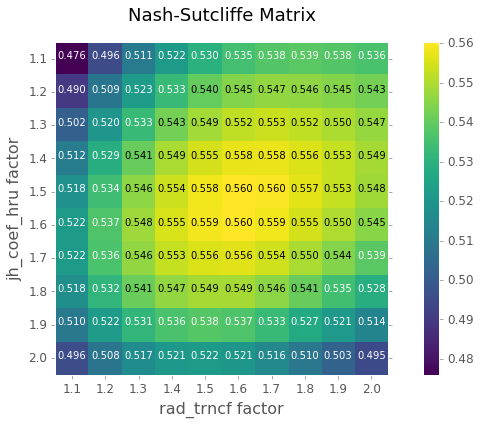

In [27]:
import itertools
fig, ax = plt.subplots()

cax = ax.matshow(nash_sutcliffe_mat, cmap='viridis')
tix = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
plt.xticks(range(10), tix)
plt.yticks(range(10), tix)


ax.xaxis.set_ticks_position('bottom')
plt.ylabel('jh_coef_hru factor')
plt.xlabel('rad_trncf factor')

for i, j in itertools.product(range(10), range(10)):
    plt.text(j, i, "%.3f" % nash_sutcliffe_mat[i, j],
             horizontalalignment="center", 
             color="w" if nash_sutcliffe_mat[i, j] < .54 else "k")

plt.title('Nash-Sutcliffe Matrix')
plt.grid(b=False)
cbar = fig.colorbar(cax)